In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews/dataset.csv


Dataset: https://www.kaggle.com/datasets/andrewmvd/steam-reviews

In [2]:
# !python -m spacy download en_core_web_md
# !pip install spacy-cleaner

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
# spacy.require_gpu()

# wordcloud 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
data = pd.read_csv("/kaggle/input/steam-reviews/dataset.csv")

In [5]:
data.head()

app_id        app_name                                        review_text  \
0      10  Counter-Strike                                    Ruined my life.   
1      10  Counter-Strike  This will be more of a ''my experience with th...   
2      10  Counter-Strike                      This game saved my virginity.   
3      10  Counter-Strike  • Do you like original games? • Do you like ga...   
4      10  Counter-Strike           Easy to learn, hard to master.             

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [7]:
data.isnull().sum()

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64

In [8]:
# first things first remove any duplicatese
data.drop_duplicates(inplace=True)

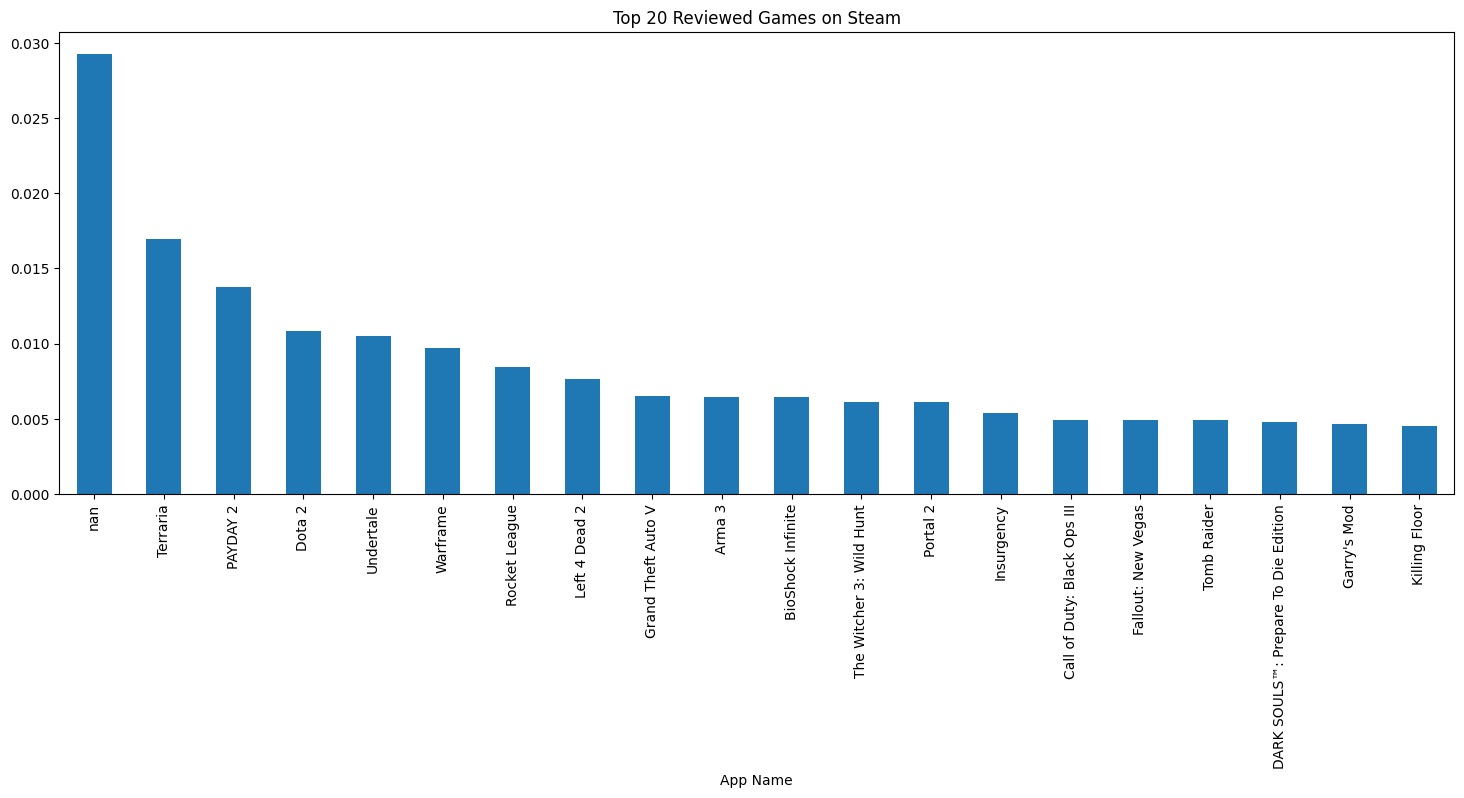

In [9]:
fig, ax = plt.subplots(figsize=(18, 6))
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

It looks like there are a large number of reviews without specifying a game. Those will be removed since we cannot use them to gauge any sentiment towards a particular game.

The reviews without any text will also be removed since we cannot understand why a user liked or disliked a game without a written review.

In [10]:
# remove null values
data = data[~data["app_name"].isnull()].copy(deep=True)
data = data[~data["review_text"].isnull()].copy(deep=True)

In [11]:
data.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4483850 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 205.3+ MB


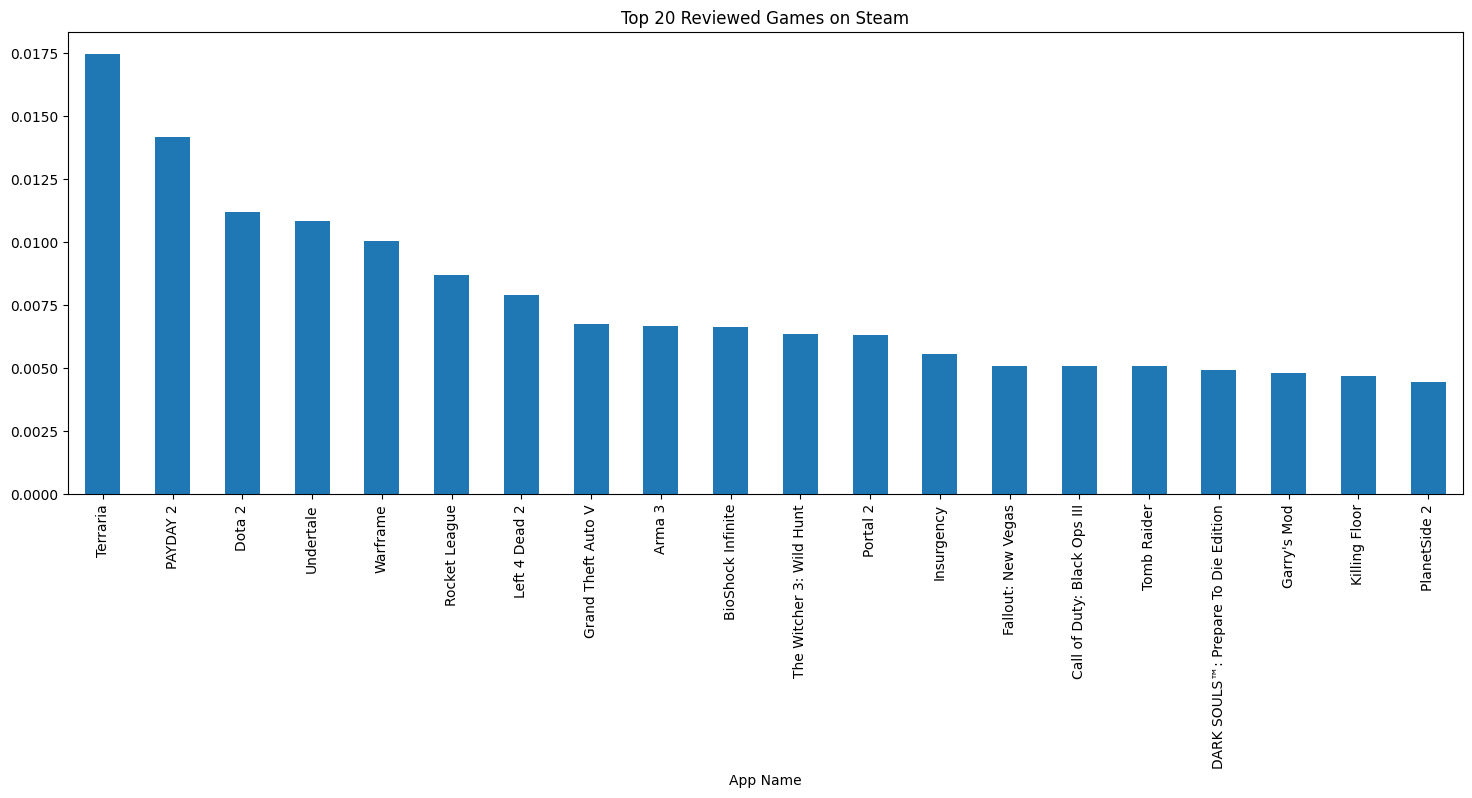

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [14]:
# how many games are reviewed on steam? at least, in this dataset
data["app_name"].nunique()

9363

It looks like some games have only one kind of review written, 'Early Access Review'. Let's remove them from our dataset since these aren't telling us anything useful about the game sentiment.

In [15]:
# example
data[data["app_name"] == "DayZ"].head()

app_id app_name             review_text  review_score  review_votes
1338872  221100     DayZ     Early Access Review             1             1
1338876  221100     DayZ     Early Access Review            -1             1
1338917  221100     DayZ     Early Access Review             1             0
1338925  221100     DayZ     Early Access Review            -1             0
1341125  221100     DayZ     Early Access Review            -1             0

In [16]:
# frequency of these reviews
data[(data["review_text"] == " Early Access Review")].shape

(4879, 5)

In [17]:
# remove reviews
data = data[(data["review_text"] != " Early Access Review")].copy(deep=True)

In [18]:
# drop reviews that are exactly the same - a rare event
data.drop_duplicates(subset=["review_text"], inplace=True)

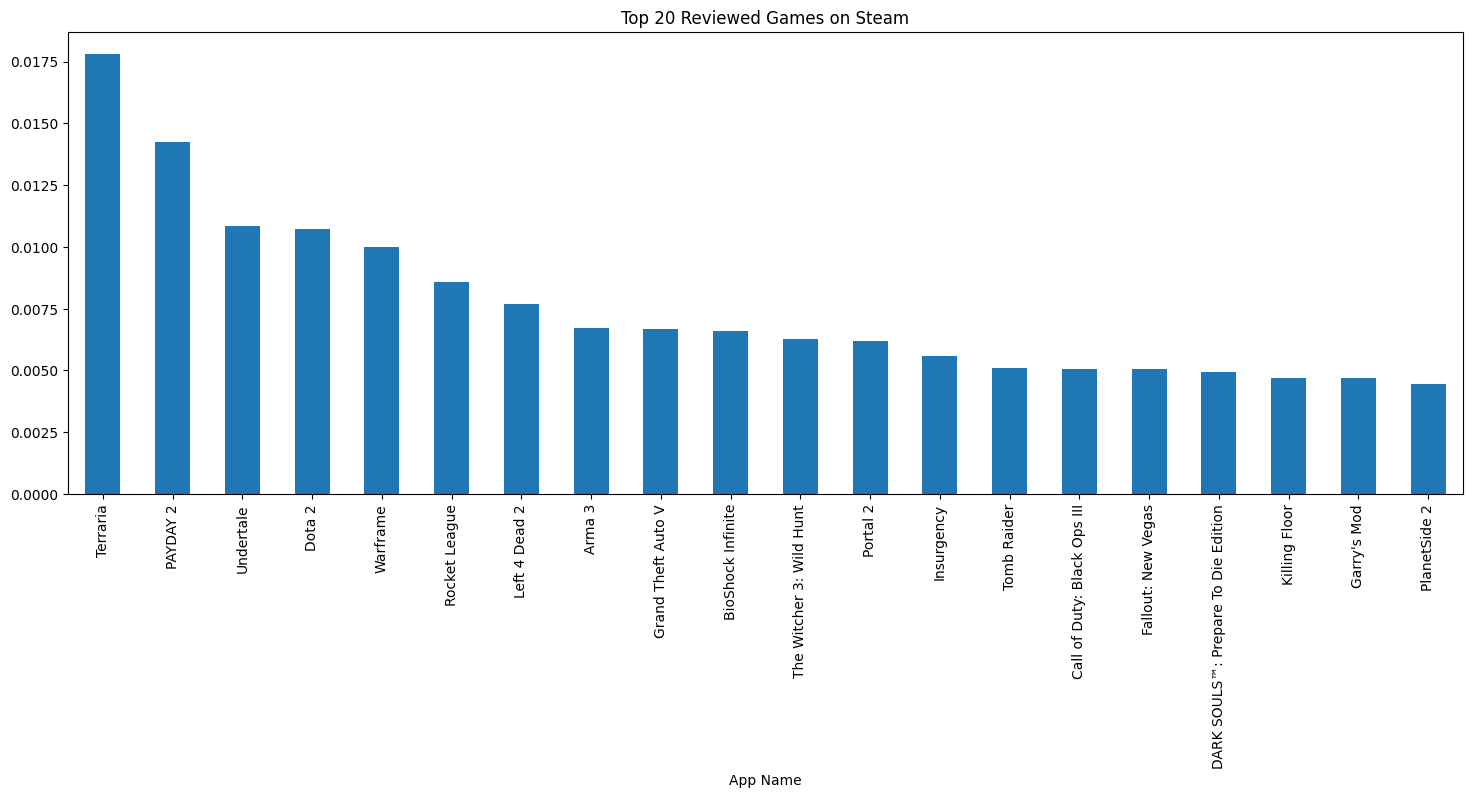

In [19]:
fig, ax = plt.subplots(figsize=(18, 6))
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [20]:
# convert review scores to 0 and 1
data["review_score"] = data["review_score"].apply(lambda x: 0 if x == -1 else 1)

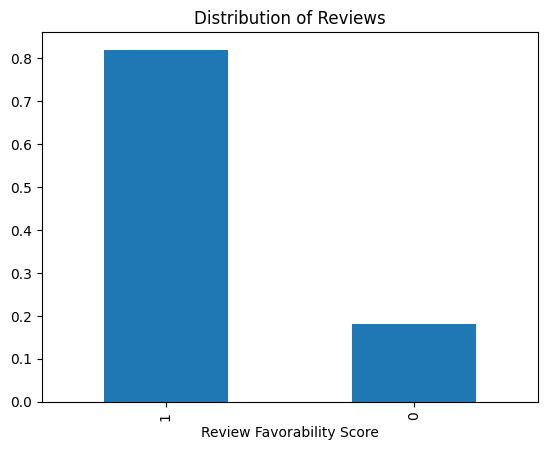

In [21]:
# majority of games are viewed favorably
data["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Reviews")
plt.xlabel("Review Favorability Score")
plt.show()

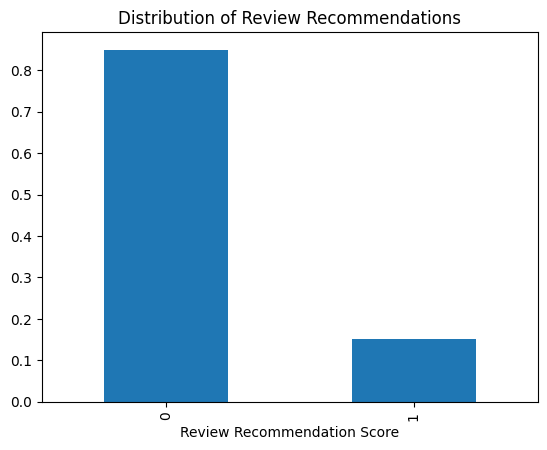

In [22]:
data["review_votes"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Review Recommendations")
plt.xlabel("Review Recommendation Score")
plt.show()

In [23]:
pd.crosstab(data["review_score"], data["review_votes"])

review_votes        0       1
review_score                 
0              590317  194320
1             3098877  460666

In [24]:
# since there are over 9000 games mentioned we will only plot the reviews of the 20 most popular games
game_list = data["app_name"].value_counts(dropna=False).head(20).index.tolist()

game_list

['Terraria',
 'PAYDAY 2',
 'Undertale',
 'Dota 2',
 'Warframe',
 'Rocket League',
 'Left 4 Dead 2',
 'Arma 3',
 'Grand Theft Auto V',
 'BioShock Infinite',
 'The Witcher 3: Wild Hunt',
 'Portal 2',
 'Insurgency',
 'Tomb Raider',
 'Call of Duty: Black Ops III',
 'Fallout: New Vegas',
 'DARK SOULS™: Prepare To Die Edition',
 'Killing Floor',
 "Garry's Mod",
 'PlanetSide 2']

In [25]:
data_plotted = data[data["app_name"].isin(game_list)].copy(deep=True)

data_plotted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659942 entries, 68092 to 6340610
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        659942 non-null  int64 
 1   app_name      659942 non-null  object
 2   review_text   659942 non-null  object
 3   review_score  659942 non-null  int64 
 4   review_votes  659942 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 30.2+ MB


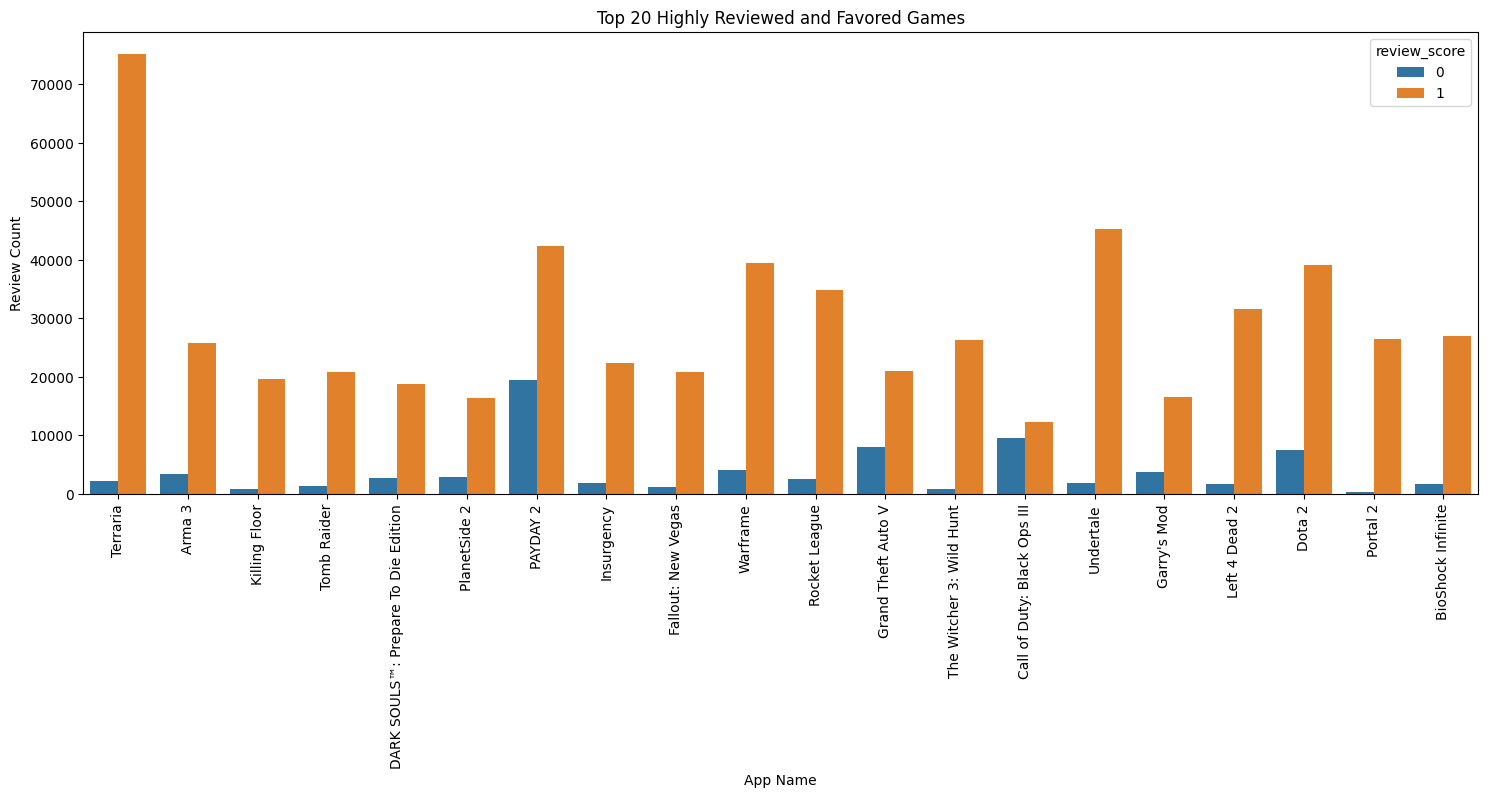

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(data=data_plotted, x="app_name", hue="review_score")
plt.title("Top 20 Highly Reviewed and Favored Games")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Count")
plt.show()

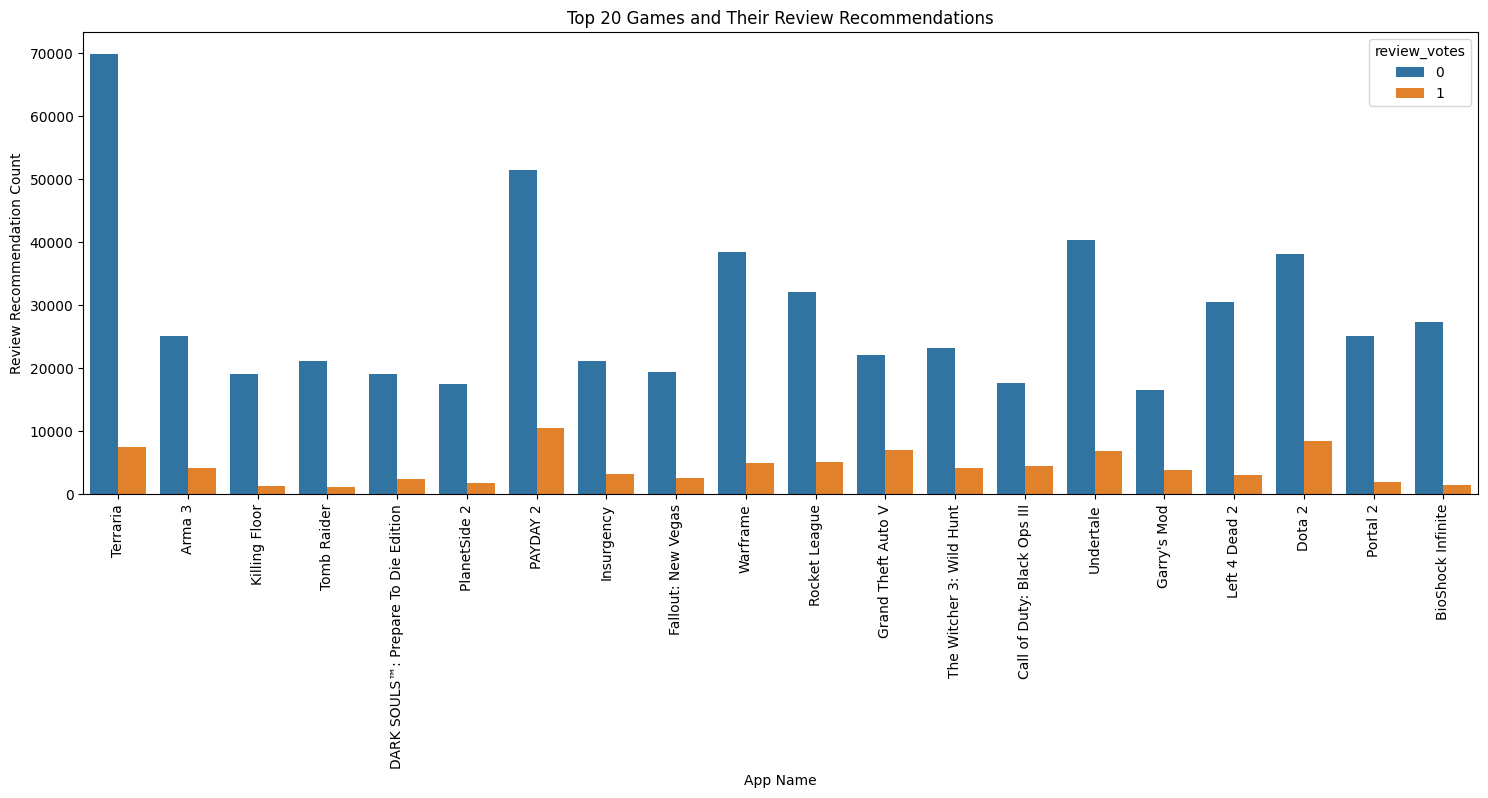

In [27]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(data=data_plotted, x="app_name", hue="review_votes")
plt.title("Top 20 Games and Their Review Recommendations")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Recommendation Count")
plt.show()

Let's take a look at the least reviewed games on Steam. Since the dataset is already quite large, we can remove any games with less than 300 reviews since having only a small number of reviews makes it harder to establish how the majority of people feel about that game.

In [28]:
# number of games after initial cleaning
data["app_name"].nunique()

8559

In [29]:
# least reviewed games
app_review_count = data["app_name"].value_counts(dropna=False).reset_index()

app_remove_least = app_review_count[app_review_count["count"] < 301]["app_name"].tolist()

In [30]:
# remove games from dataset
data = data[~data["app_name"].isin(app_remove_least)].copy(deep=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3911290 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 179.0+ MB


After the initial cleaning we're left with around 4 million data points, which is still a lot of data. To make the rest of the processing easier, we'll take roughly 20% and 5% from our remaining dataset.

Looking at the distribution of positive to negative reviews, there are far more positive than negative reviews. This is a case of imbalanced classification. Later on, when we are building our models, we will make sure to even the classes using SMOTE and ENN.

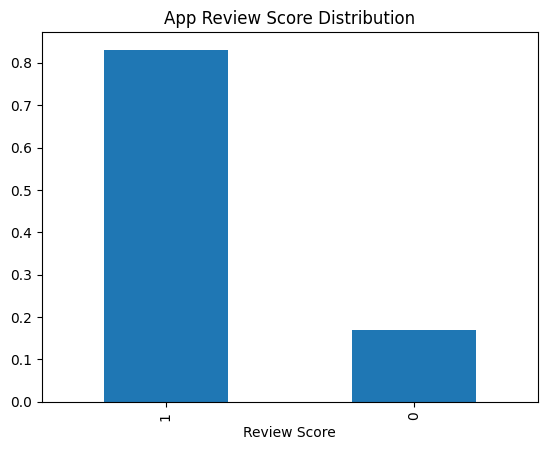

In [32]:
# revisit positive/negative review counts
data["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("App Review Score Distribution")
plt.xlabel("Review Score")
plt.show()

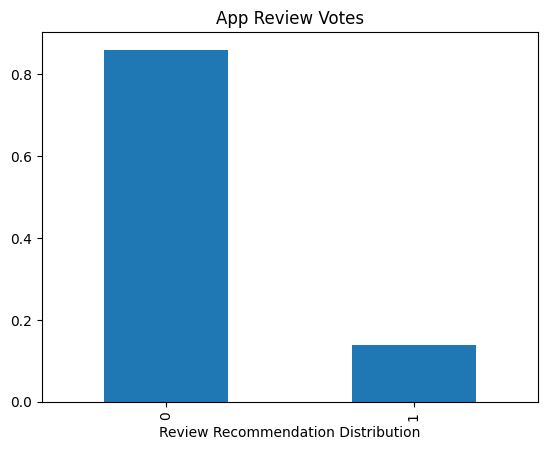

In [33]:
data["review_votes"].value_counts(normalize=True).plot(kind="bar")
plt.title("App Review Votes")
plt.xlabel("Review Recommendation Distribution")
plt.show()

## Taking a Data Subset

In [34]:
# take 20% sample from dataset
# data_subset = data.sample(frac=0.20, random_state=42)

In [35]:
# take 5% sample from dataset - for quicker model creation
data_subset = data.sample(frac=0.05, random_state=42)

In [36]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195564 entries, 2092403 to 942527
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        195564 non-null  int64 
 1   app_name      195564 non-null  object
 2   review_text   195564 non-null  object
 3   review_score  195564 non-null  int64 
 4   review_votes  195564 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


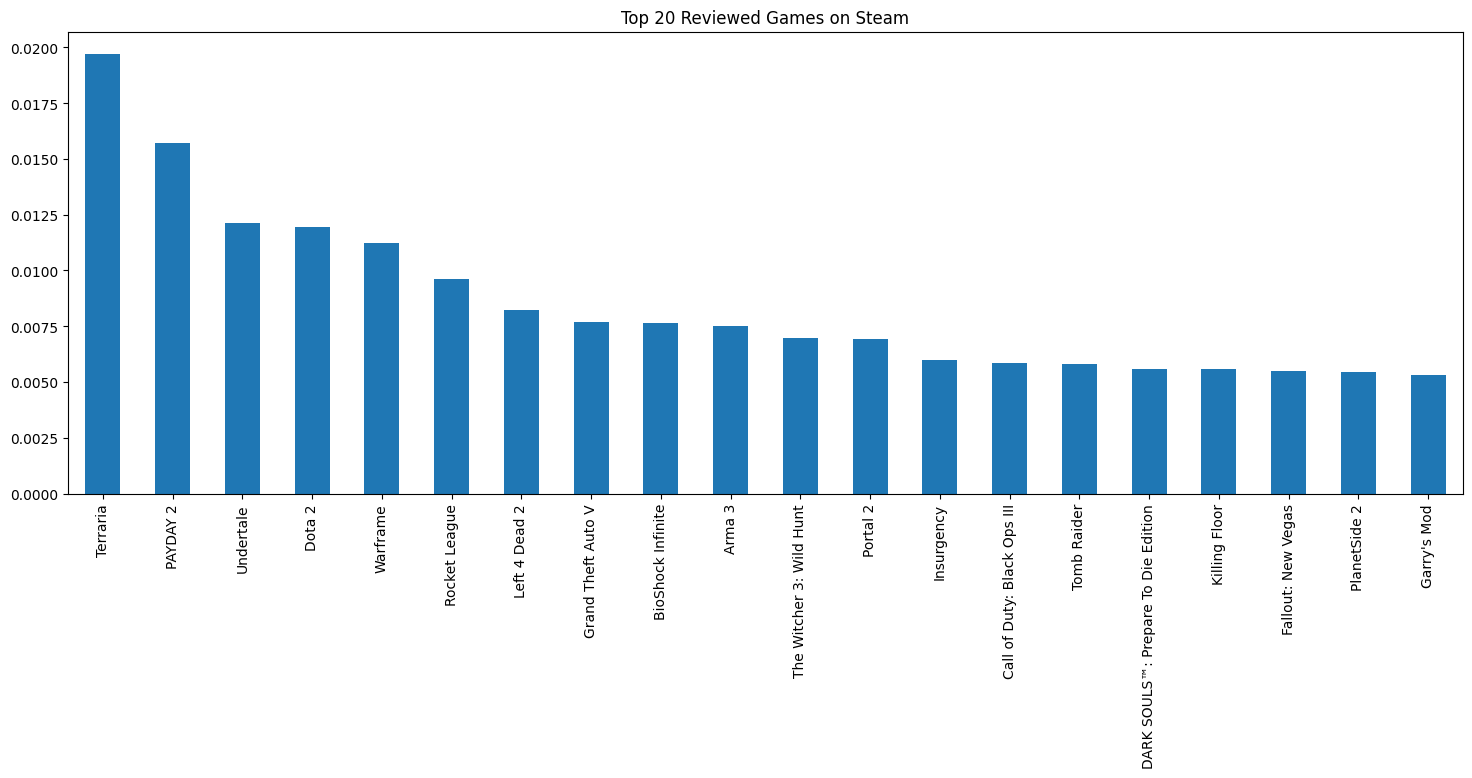

In [37]:
fig, ax = plt.subplots(figsize=(18, 6))
data_subset["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("")
plt.show()

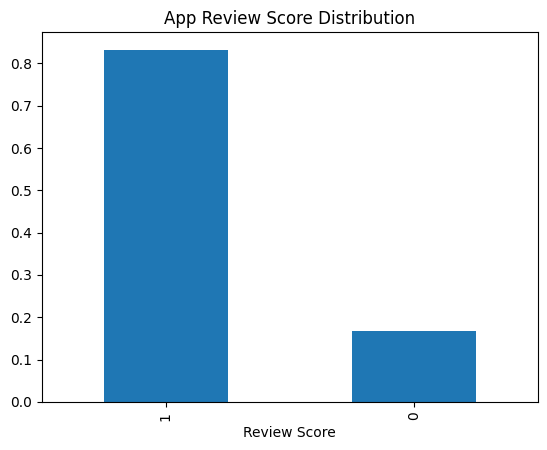

In [38]:
# revisit positive/negative review counts
data_subset["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("App Review Score Distribution")
plt.xlabel("Review Score")
plt.show()

In [39]:
pd.crosstab(data_subset["review_score"], data_subset["review_votes"])

review_votes       0      1
review_score               
0              25135   7737
1             143433  19259

In [40]:
# most popular reviewed games on subset
subset_top = data_subset["app_name"].value_counts(dropna=False).head(20).index.tolist()

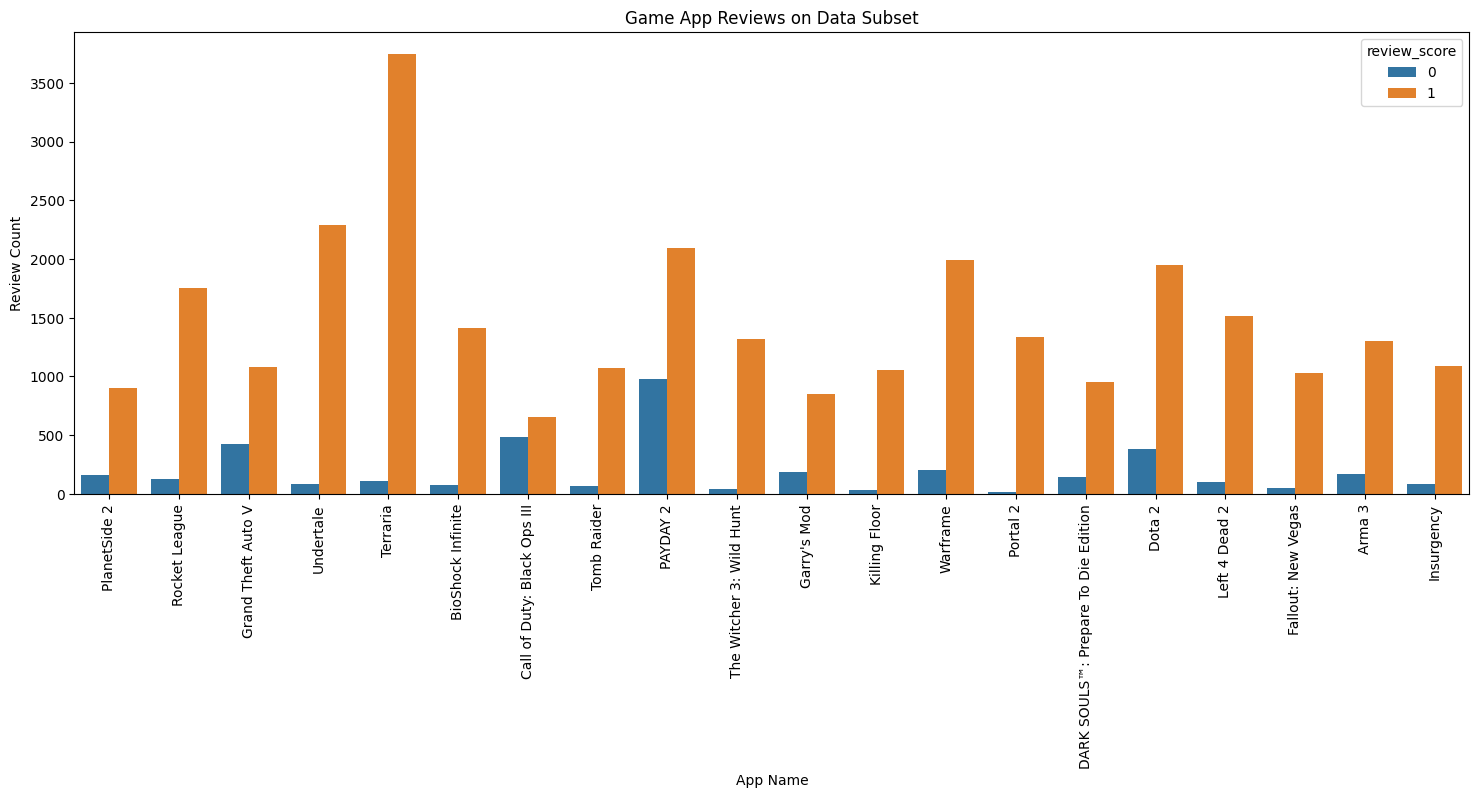

In [41]:
data_subset_top = data_subset[data_subset["app_name"].isin(subset_top)]

fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(data=data_subset_top, x="app_name", hue="review_score")
plt.title("Game App Reviews on Data Subset")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Count")
plt.show()

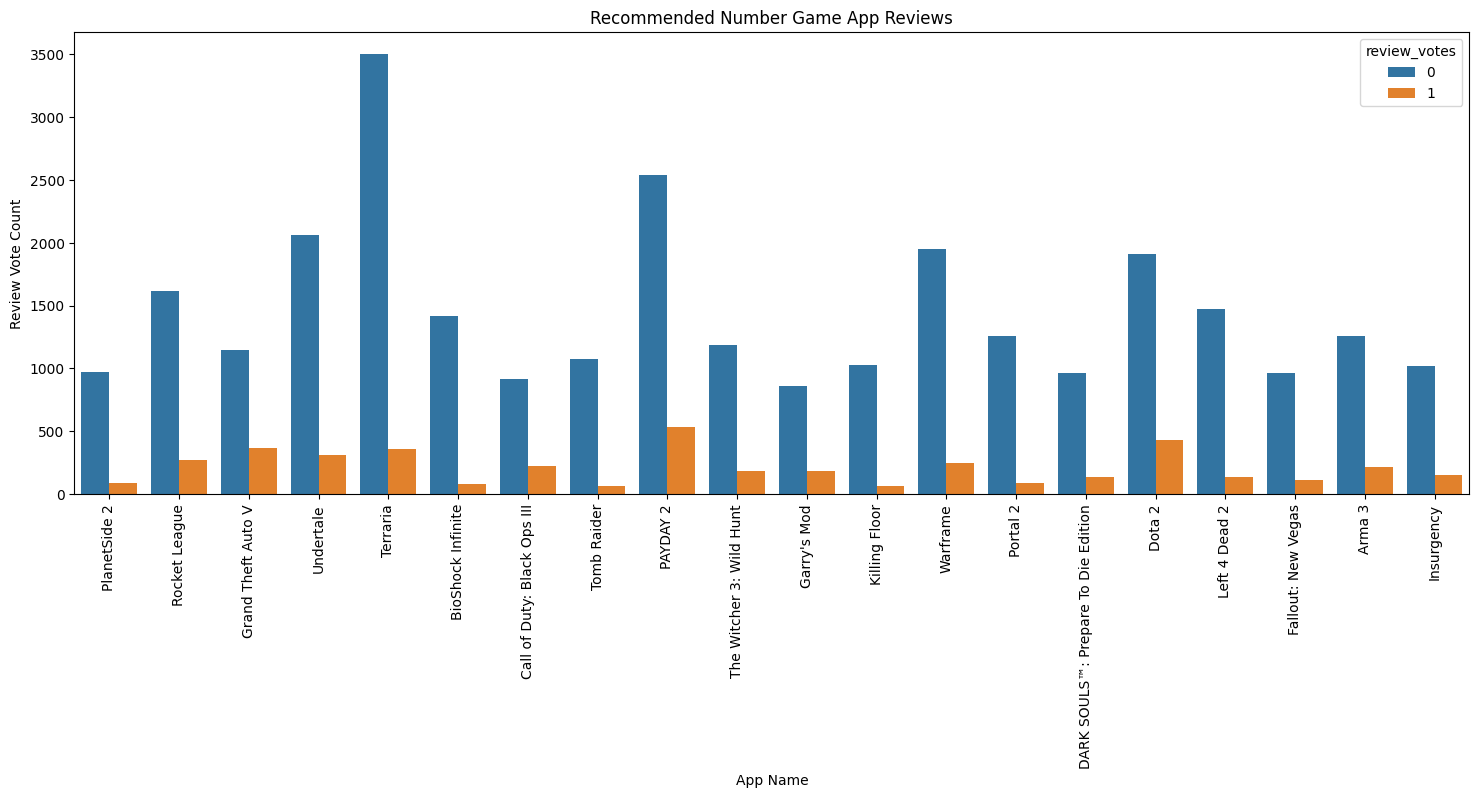

In [42]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(data=data_subset_top, x="app_name", hue="review_votes")
plt.title("Recommended Number Game App Reviews")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Vote Count")
plt.show()

## Generate WordClouds by Game Top 20

Before we get continue with text processing on our subset, let's go back and take a look at some wordclouds for the top 20 games.

In [43]:
# function to generate wordcloud based on game
def game_wordcloud(game):
    app_df = data_subset[data_subset["app_name"] == game].copy(deep=True)

    app_review = " ".join(rev for rev in app_df["review_text"])
    
    wordcloud = WordCloud(colormap="tab10_r").generate(app_review)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(game + " App Reviews Wordcloud")
    plt.axis("off")
    plt.show()

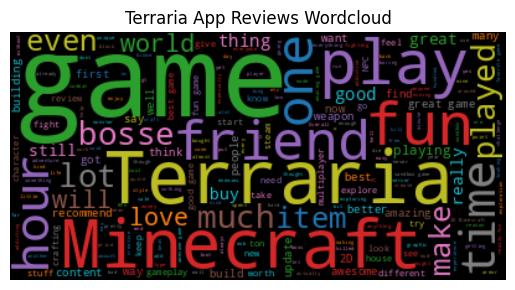

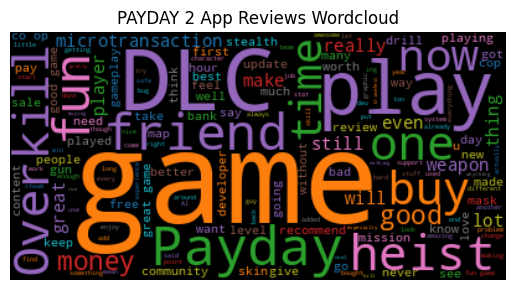

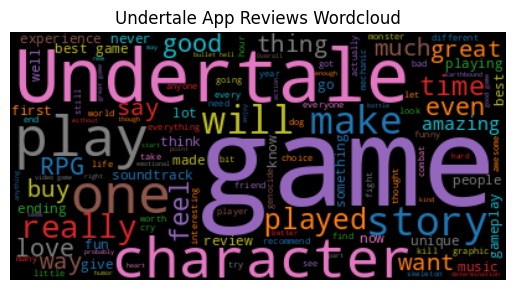

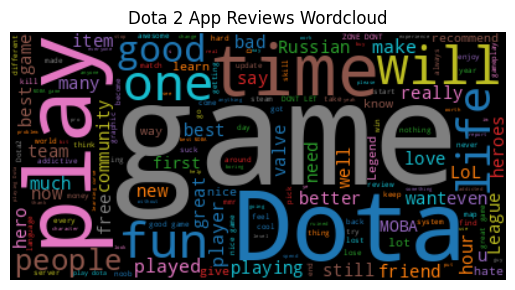

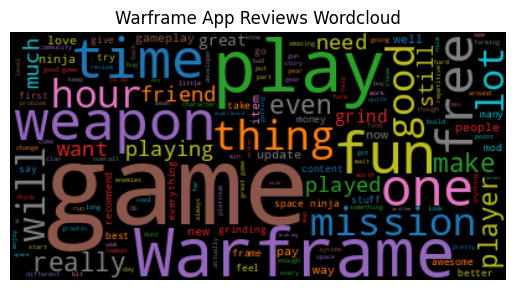

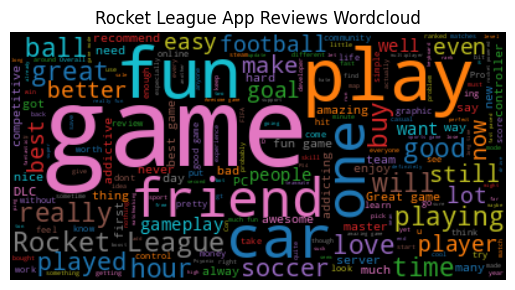

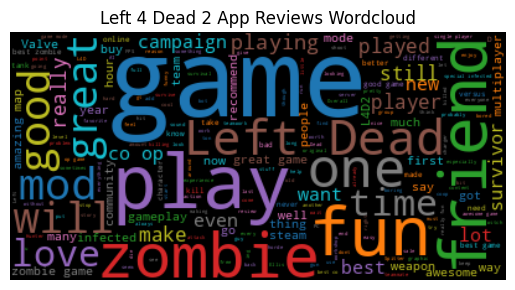

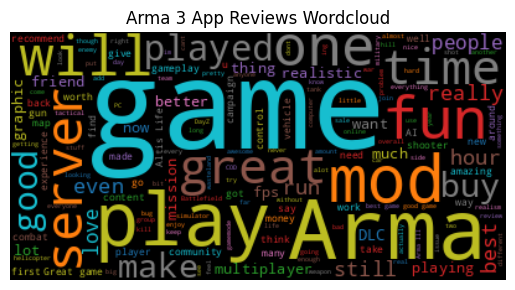

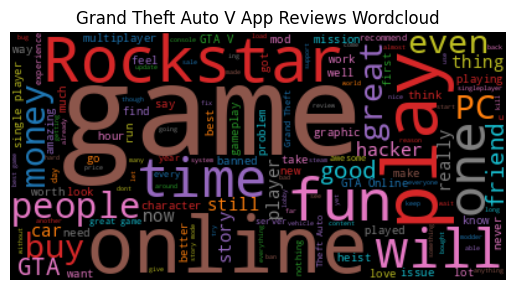

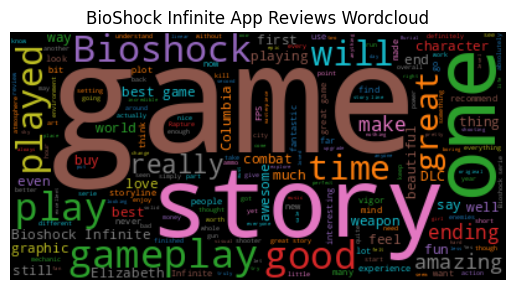

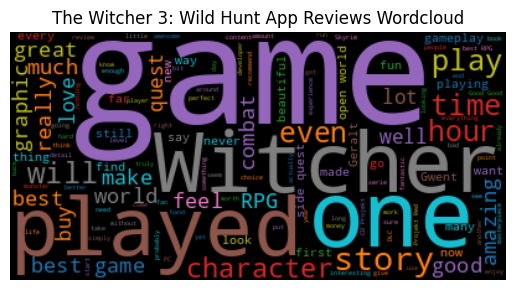

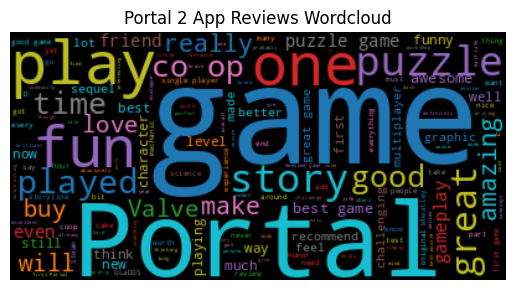

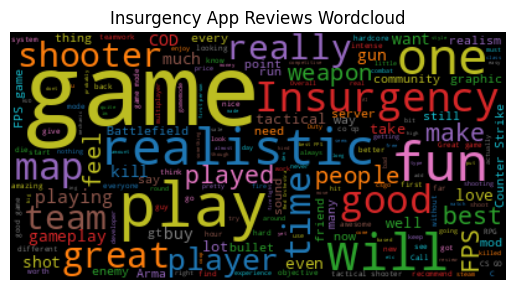

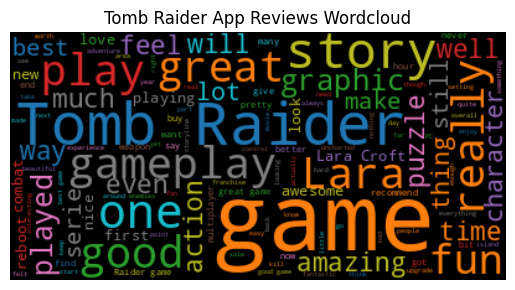

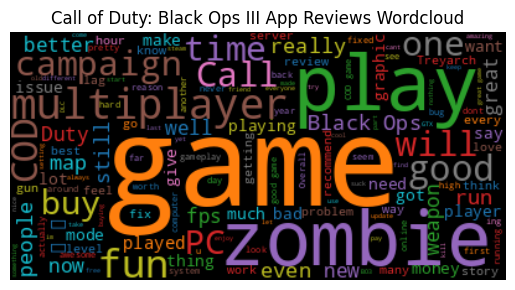

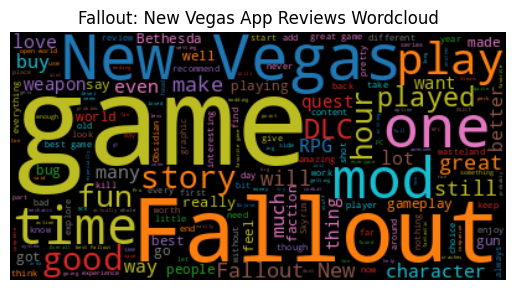

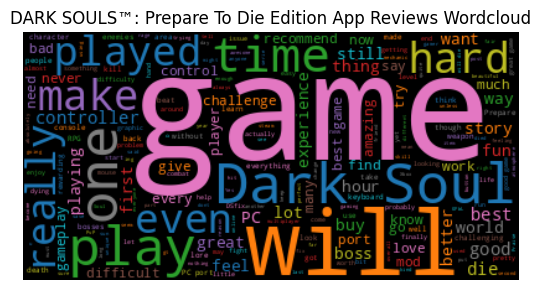

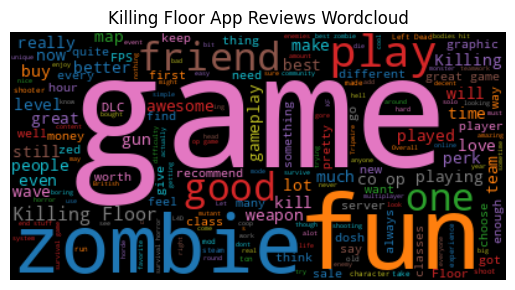

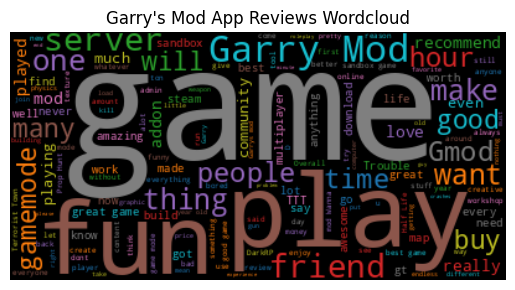

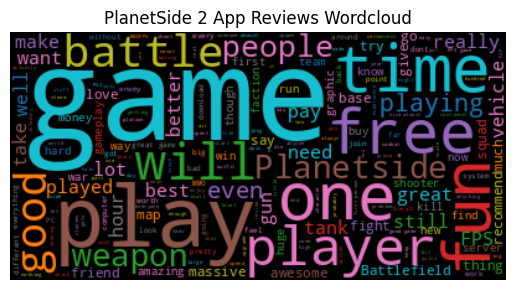

In [44]:
for game in game_list: 
    game_wordcloud(game)

In [45]:
# check for any reviews that are not string text
# for x in range(len(app_example["review_text"])):
#     if type(app_example["review_text"].iloc[x]) is not str:
#         print(x)

In [46]:
# 195564
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195564 entries, 2092403 to 942527
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        195564 non-null  int64 
 1   app_name      195564 non-null  object
 2   review_text   195564 non-null  object
 3   review_score  195564 non-null  int64 
 4   review_votes  195564 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


In [47]:
# save the subset for text processing and modeling
# data_subset.to_csv("steam_reviews_subset_20_new.csv", index=False)

In [48]:
# save the subset for text processing and modeling
# data_subset.to_csv("steam_subset_5_new.csv", index=False)